In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
import torch.optim as optim


In [20]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/DIG Historical Data 2018.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [21]:
df1=df.reset_index()['Price']
df1.head()

0    11033.2
1    11457.6
2    12094.1
3    12094.1
4    12200.2
Name: Price, dtype: float64

In [22]:
df1

0       11033.2
1       11457.6
2       12094.1
3       12094.1
4       12200.2
         ...   
1547    30450.0
1548    29900.0
1549    30400.0
1550    31700.0
1551    31950.0
Name: Price, Length: 1552, dtype: float64

In [23]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [24]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [25]:
test_size

310

In [26]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [27]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [28]:
X_train.shape

(1140, 100)

In [29]:
# Tạo Dataset cho PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [30]:
# Định nghĩa mô hình ResNetLSTM
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNetLSTM(Module):
    def __init__(self, c_in, c_out, lstm_hidden_units=50, num_lstm_layers=1):
        super().__init__()
        nf = 64
        kss = [7, 5, 3]
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.lstm = nn.LSTM(nf * 2, lstm_hidden_units, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = x.transpose(1, 2)  # Transpose for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Lấy đầu ra của LSTM ở bước thời gian cuối cùng
        x = self.fc(x)
        return x

In [31]:
# Khởi tạo mô hình
model = ResNetLSTM(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Huấn luyện mô hình
num_epochs = 80    # DIG: 80
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/80, Loss: 0.03456488996744156, Test Loss: 0.02663370966911316
Epoch 2/80, Loss: 0.00488911522552371, Test Loss: 0.00396408059168607
Epoch 3/80, Loss: 0.001260900404304266, Test Loss: 0.0008046331204241142
Epoch 4/80, Loss: 0.0006568549433723092, Test Loss: 0.0006005036921123974
Epoch 5/80, Loss: 6.966327055124566e-05, Test Loss: 9.801734631764702e-05
Epoch 6/80, Loss: 4.7692228690721095e-05, Test Loss: 7.633936547790654e-05
Epoch 7/80, Loss: 5.1896295190090314e-05, Test Loss: 6.592121644644067e-05
Epoch 8/80, Loss: 8.997874101623893e-05, Test Loss: 9.978980597225018e-05
Epoch 9/80, Loss: 6.224075332283974e-05, Test Loss: 8.844376861816272e-05
Epoch 10/80, Loss: 0.0001768326765159145, Test Loss: 0.00033431148403906263
Epoch 11/80, Loss: 0.00040173332672566175, Test Loss: 0.00033165665445267223
Epoch 12/80, Loss: 0.0002488638274371624, Test Loss: 0.00019105587125523016
Epoch 13/80, Loss: 0.0002403052058070898, Test Loss: 0.0001493256277171895
Epoch 14/80, Loss: 8.508261089446023e

In [33]:
# Dự báo dữ liệu test
model.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [34]:
# Dự báo 30 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output.extend(yhat.detach().numpy().tolist())

lst_output = scaler.inverse_transform(lst_output)

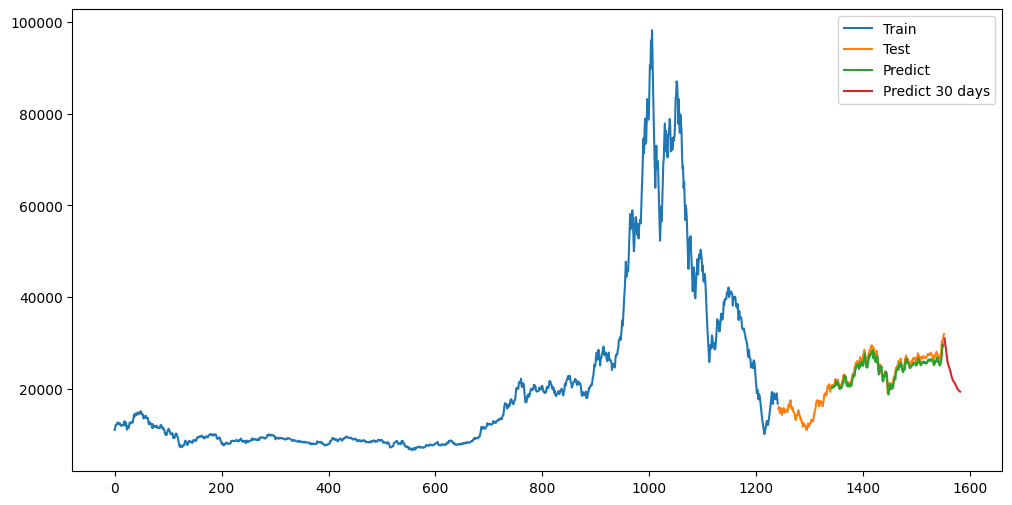

In [35]:
# Vẽ hình
plt.figure(figsize=(12, 6))
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index, lst_output, label='Predict 30 days')

plt.legend()
plt.show()